In [1]:
from collections import defaultdict
from multiprocessing import Pool

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from consent.consistency.cookie_pref_match import cookie_pref_match
from consent.consistency.util import FIG_DIR, get_scan_dirs, get_scan_root_dir
from consent.data.pref_menu_scan.cookie_pref_reader import read_cookie_prefs_in_scans
from consent.data.pref_menu_scan.log_reader import read_logs_in_scans
from consent.data.pref_menu_scan.cookie_decl_reader import read_cookie_decls_in_scans
from consent.data.pref_menu_scan.har_cookie_reader import read_postrej_sent_cookies_in_scans
from ooutil.type_util import hashabledict

SCAN_DIRS = get_scan_dirs('us')
SCAN_ROOT_DIR = get_scan_root_dir('us')

In [2]:
SCAN_DIRS

[PosixPath('/mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2021-12-15/pref_menu_scan_0k_10k'),
 PosixPath('/mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2021-12-15/pref_menu_scan_10k_30k'),
 PosixPath('/mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2021-12-15/pref_menu_scan_30k_50k')]

In [3]:
# Get cookie prefs = cookie decls + prefs
cookie_prefs = read_cookie_prefs_in_scans(SCAN_DIRS)  # Took 38sec. or 7 min for 50k-site scan
cookie_prefs.head()
# TODO: add log_file_checker

Error reading intel.co.uk dictionary update sequence element #0 has length 1; 2 is required
Fail to read log 1 sites: ['intel.co.uk'] 
 "None of [Index(['name', 'domain', 'duration', 'category_id', 'category',\n       'consent_mode'],\n      dtype='object')] are in the [columns]"WARNING: error decoding /mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2021-12-15/pref_menu_scan_0k_10k/eero.com/consent_resources.json: region_block Received an out-of-region response
https://cdn-ukwest.onetrust.com/consent/e00c3e10-0e07-461a-94d5-e87b899fa55a/442b5be0-8f10-4555-b6a6-2aa7c2e23dfa/en.json WARNING: Cookie list has session cookie but duration > 0
https://cdn.cookielaw.org/consent/be922b85-1c88-4393-ae73-1523f02934d6/366288bf-75c8-472c-b77b-7724367eecb9/en.json WARNING: Cookie list has session cookie but duration > 0
https://cdn.cookielaw.org/consent/bfc3f6d1-88f6-4292-b5d2-757633a696fe/e872bfc4-cfdc-444e-804c-eee5dcb46285/en.json WARNING: Cookie list has sessi

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
0,__we_bucket_id,www.wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,True
1,OptanonAlertBoxClosed,wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,True
2,OptanonConsent,www.wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,True
3,__we_request_id,www.wework.com,Session,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,True
4,we_referring_domain,www.wework.com,14 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,True


In [4]:
cookielist_sites = sorted(cookie_prefs.site.unique().tolist())
n_cookielist_sites = len(cookielist_sites)
assert cookie_prefs.site.nunique() == n_cookielist_sites
n=10
print("Sites with cookie prefs:", n_cookielist_sites, f', first {n} sites:' , cookielist_sites[:n])

Sites with cookie prefs: 1623 , first 10 sites: ['10fastfingers.com', '24hourfitness.com', '24s.com', '2k.com', '2kgames.com', '2ksports.com', '2o7.net', '3dmark.com', '3dsystems.com', '451research.com']


In [5]:
site_to_libname = {row['site']: row['lib_name'] for row in cookie_prefs[['site', 'lib_name']].drop_duplicates().to_dict('records')}

In [6]:
# print("Libs in failed-to-crawl sites")
# errors.consent_lib_name.value_counts()

In [7]:
# # Distribution of errors
# from ooutil.df_util import expand_dict_col
# ot_errs = errors[errors.consent_lib_name == 'onetrust']
# errors_dict = pd.DataFrame(ot_errs.error.tolist()).explode('reason')
# # Uncomment to show
# # errors_dict.reason.value_counts()

In [8]:
# ot_errs[ot_errs.site == 'doodle.com'].error.iloc[0]

In [9]:
# ot_errs[ot_errs.error.str.contains('waiting for selector')]

In [10]:
# cb_errs = errors[errors.consent_lib_name == 'cookiebot_legacy']
# cb_errs
# pd.DataFrame(cb_errs.error.tolist()).explode('reason')

# Main analysis

In [11]:
import sys; import importlib; importlib.reload(sys.modules['consent.data.pref_menu_scan.har_cookie_reader'])
from consent.data.pref_menu_scan.har_cookie_reader import read_postrej_sent_cookies_in_scans


overwrite = False
cookies_cache_file = SCAN_ROOT_DIR / 'scan.parquet'  # 'raw_postrej_sent_cookies.parquet'

if not overwrite and cookies_cache_file and cookies_cache_file.exists():
    sent_cookies = pd.read_parquet(cookies_cache_file)
else:
    sent_cookies = read_postrej_sent_cookies_in_scans(SCAN_DIRS)
    if cookies_cache_file: sent_cookies.to_parquet(cookies_cache_file); print(f"Written to {cookies_cache_file}")

print(f"Number sent cookies read: {len(sent_cookies):,d}")
sent_cookies.head(3)

Number sent cookies read: 5,152,870


,name,value,domain,path,expires,size,httpOnly,secure,session,sameSite,priority,sameParty,sourceScheme,sourcePort,request_url,site,page_url
0,ajs_user_id,%22e465a0f34b3bdaa686645b9f88599d5563d0e8562db...,.wework.com,/,1.671123e+09,81,False,False,False,Lax,Medium,False,Secure,443,https://www-static.wework.com/apercu/apercu_mo...,wework.com,https://www.wework.com/l/coworking-space/manila
1,_ga,GA1.1.1271302899.1639586858,.wework.com,/,1.702659e+09,30,False,False,False,None,Medium,False,Secure,443,https://www.wework.com/vanilla-assets/javascri...,wework.com,https://www.wework.com/l/coworking-space/manila
2,ajs_user_id,%22e465a0f34b3bdaa686645b9f88599d5563d0e8562db...,.wework.com,/,1.671123e+09,81,False,False,False,Lax,Medium,False,Secure,443,https://www.wework.com/vanilla-assets/fonts/ic...,wework.com,https://www.wework.com/l/coworking-space/manila


In [12]:
# prj = post-rejection
prj_sent_cookies = sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'value', 'request_url', 'site']].drop_duplicates()
prj_br_cookies = prj_sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'site']].drop_duplicates()

In [13]:
print(f"Num captured sent cookies: {len(sent_cookies):,d}")
print(f"Num unique captured cookies: {len(prj_sent_cookies):,d}")
n_br_cookies = len(prj_br_cookies)
print(f"Num unique browser cookies: {n_br_cookies:,d} on {sent_cookies.page_url.nunique():,d} websites") # and {sent_cookies.page_url.nunique():,d} pages")

Num captured sent cookies: 5,152,870
Num unique captured cookies: 3,071,691
Num unique browser cookies: 122,256 on 9,139 websites


## Analyze cookies compliance    

In [14]:
from consent.consistency.comply_util import get_comply

print("faster: for cookie_pref in cookie_pref_set[cookie_pref_set.name == acookie['name']]:")
all_complies = get_comply(cookie_prefs, prj_sent_cookies)
all_complies.head()

faster: for cookie_pref in cookie_pref_set[cookie_pref_set.name == acookie['name']]:


  0%|          | 4/1623 [00:01<09:36,  2.81it/s]

Contradictory set: site='genial.ly' contra_set={{'domain': 'app.genial.ly', 'name': '__stripe_sid'}, {'domain': 'app.genial.ly', 'name': '__stripe_mid'}}


  0%|          | 6/1623 [00:02<15:39,  1.72it/s]

Contradictory set: site='ulta.com' contra_set={{'domain': 'ulta.com', 'name': '_schn'}}


  2%|▏         | 33/1623 [00:15<13:30,  1.96it/s]

Contradictory set: site='piriform.com' contra_set={{'domain': 'ccleanercom-production-slave.azurewebsites.net', 'name': 'ARRAffinity'}}


  3%|▎         | 45/1623 [00:20<09:29,  2.77it/s]

Contradictory set: site='cell.com' contra_set={{'domain': 'hubspot.net', 'name': '__cfduid'}}


  4%|▍         | 69/1623 [00:31<33:31,  1.29s/it]

Contradictory set: site='checkout.com' contra_set={{'domain': 'static.cdn.prismic.io', 'name': 'io.prismic.preview'}}


  4%|▍         | 71/1623 [00:33<26:08,  1.01s/it]

Contradictory set: site='adobeconnect.com' contra_set={{'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}, {'domain': 'app-aba.marketo.com', 'name': '__cf_bm'}}


  4%|▍         | 73/1623 [00:34<17:42,  1.46it/s]

Contradictory set: site='returnpath.net' contra_set={{'domain': 'app.jazz.co', 'name': 'SF_PHPSESSID'}, {'domain': 'community.validity.com', 'name': 'cookieTest'}}


  5%|▌         | 86/1623 [00:39<20:34,  1.25it/s]

Contradictory set: site='echosign.com' contra_set={{'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}, {'domain': 'app-aba.marketo.com', 'name': '__cf_bm'}}


  5%|▌         | 88/1623 [00:40<15:43,  1.63it/s]

Contradictory set: site='aon.com' contra_set={{'domain': 'insights.humancapital.aon.com', 'name': 'ufentry'}, {'domain': 'sleeknotestaticcontent.sleeknote.com', 'name': 'SNS'}}


  6%|▌         | 91/1623 [00:41<11:08,  2.29it/s]

Contradictory set: site='balenciaga.com' contra_set={{'domain': 'www.balenciaga.com', 'name': '_cs_same_site'}}


  6%|▌         | 94/1623 [00:42<08:39,  2.94it/s]

Contradictory set: site='statista.com' contra_set={{'domain': 'm6r.eu', 'name': 'id'}}


  6%|▌         | 98/1623 [00:43<08:12,  3.10it/s]

Contradictory set: site='currys.co.uk' contra_set={{'domain': 'www.currys.co.uk', 'name': 'cookietest'}}


  6%|▌         | 100/1623 [00:46<22:46,  1.11it/s]

Contradictory set: site='accorhotels.com' contra_set={{'domain': 'all.accor.com', 'name': 'cookietest'}}


  6%|▋         | 102/1623 [00:47<22:49,  1.11it/s]

Contradictory set: site='meraki.com' contra_set={{'domain': 'cisco.com', 'name': '_vapi'}}


  6%|▋         | 104/1623 [00:51<34:49,  1.38s/it]

Contradictory set: site='magentocommerce.com' contra_set={{'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}}


  7%|▋         | 108/1623 [00:59<48:49,  1.93s/it]

Contradictory set: site='vmware.com' contra_set={{'domain': 'communities.vmware.com', 'name': 'LithiumCookiesAccepted'}}


  7%|▋         | 109/1623 [00:59<38:21,  1.52s/it]

Contradictory set: site='ledger.com' contra_set={{'domain': 'shop.ledger.com', 'name': 'cookietest'}}


  7%|▋         | 110/1623 [01:00<29:22,  1.17s/it]

Contradictory set: site='frontiersin.org' contra_set={{'domain': 'zendesk.frontiersin.org', 'name': 'cf_chl_seq_xxxxxxxxxxxxxxx'}}


  7%|▋         | 118/1623 [01:04<22:55,  1.09it/s]

Contradictory set: site='demdex.net' contra_set={{'domain': 'app-sj16.marketo.com', 'name': '__cfduid'}, {'domain': 'app-aba.marketo.com', 'name': '__cf_bm'}}


100%|██████████| 1623/1623 [11:34<00:00,  2.34it/s]


,domain,expires,name,path,sameSite,secure,value,request_url,site,comply
0,.wework.com,1.671123e+09,ajs_user_id,/,Lax,False,%22e465a0f34b3bdaa686645b9f88599d5563d0e8562db...,https://www-static.wework.com/apercu/apercu_mo...,wework.com,comply
1,.wework.com,1.702659e+09,_ga,/,None,False,GA1.1.1271302899.1639586858,https://www.wework.com/vanilla-assets/javascri...,wework.com,comply
2,.wework.com,1.671123e+09,ajs_user_id,/,Lax,False,%22e465a0f34b3bdaa686645b9f88599d5563d0e8562db...,https://www.wework.com/vanilla-assets/fonts/ic...,wework.com,comply
3,www.wework.com,1.639601e+09,_gd_session,/,None,True,7245fb13-c2cf-4c94-8be5-e2089d00f378,https://www.wework.com/vanilla-assets/javascri...,wework.com,omit
4,.krxd.net,1.655139e+09,_kuid_,/,None,True,OiuKv-_v,https://cdn.krxd.net/userdata/get?pub=6667d5d3...,wework.com,comply


In [15]:
# Record the analysis results
all_complies_file = SCAN_ROOT_DIR / 'all_complies.parquet'
all_complies.to_parquet(all_complies_file); print(f"Written {len(all_complies):,d} records of all_complies to {all_complies_file}")

Written 3,059,527 records of all_complies to /mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2021-12-15/all_complies.parquet


In [16]:
from consent.consistency.comply_util import site_to_contras
detected_contra_sites = [s for s, contras in site_to_contras.items() if len(contras) > 0]; len(detected_contra_sites)

198

In [17]:
nsites = all_complies.site.nunique(); nsites

1615

In [18]:
from collections import Counter
libs = [site_to_libname[site] for site in all_complies.site.unique()]
Counter(libs)

Counter({'onetrust': 1434, 'cookiebot': 181})

In [19]:
complies = all_complies[ ['name', 'domain', 'site', 'comply',]].drop_duplicates()
comply_counts = complies.comply.value_counts()
comply_counts

omit         25885
incorrect    14041
comply       10235
ambiguous      138
Name: comply, dtype: int64

In [20]:
def get_site_comply_type(site_complies):
    assert site_complies.site.nunique() == 1
    site = site_complies.site.unique()[0]
    site_comply_counts = site_complies.comply.value_counts().to_dict()
    if all(site_comply_counts.get(cp_type, 0) == 0 for cp_type in ['omit', 'incorrect', 'ambiguous']):
        assert site_comply_counts.get('comply', 0) > 0, f'{site} has no comply cookie flows'
        return 'comply'
    if site_comply_counts.get('incorrect', 0) > 0:
        return 'incorrect'
    if site_comply_counts.get('omit', 0) > 0:
        return 'exp_omit'
    if site_comply_counts.get('ambiguous', 0) > 0:
        return 'exp_ambiguous'    
    return None
        
def get_comply_sites(complies_df):
    site_comply_data = []
    for site in all_complies.site.unique():
        site_complies_df = complies_df[ complies_df.site == site ]
        site_comply_data.append({
            'site': site,
            'comply': get_site_comply_type(site_complies_df)
        })
    return pd.DataFrame(site_comply_data)

site_comly_df = get_comply_sites(complies)        

In [21]:
# only consider incorrect and comply
site_comply_counts = site_comly_df.comply.value_counts()
site_comply_counts 

incorrect    1333
exp_omit      207
comply         75
Name: comply, dtype: int64

In [22]:
comply_sites_data = defaultdict(list)
for comply_type, group in complies.groupby('comply'):
    if comply_type in ['incorrect', 'comply']:
        n_sites = site_comply_counts.to_dict().get(comply_type, 0)
    else:
        n_sites = group.site.nunique()
    comply_sites_data['comply_type'].append(comply_type)
    comply_sites_data['num_sites'].append(n_sites)

    comply_sites = pd.DataFrame(comply_sites_data).sort_values(by=['num_sites'], ascending=False)
    

comply_sites['num_sites_percent'] = comply_sites['num_sites'] / nsites * 100
comply_sites['num_cookies'] = comply_sites['comply_type'].map(comply_counts)
comply_sites['num_cookies_percent'] = comply_sites['num_cookies'] / n_br_cookies * 100
comply_sites['num_cookies_per_site'] = comply_sites['num_cookies'] / comply_sites['num_sites'] 

noncomply_sites = comply_sites[comply_sites.comply_type != 'comply']
comply_sites

,comply_type,num_sites,num_sites_percent,num_cookies,num_cookies_percent,num_cookies_per_site
3,omit,1471,91.083591,25885,21.172785,17.596873
2,incorrect,1333,82.538700,14041,11.484917,10.533383
1,comply,75,4.643963,10235,8.371777,136.466667
0,ambiguous,72,4.458204,138,0.112878,1.916667


In [23]:
latex = comply_sites[['comply_type', 'num_cookies', 'num_sites', 'num_sites_percent']].copy()
# latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites']} ({row['num_sites_percent']:.2f}%)", axis=1)
latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites_percent']:.2f}% ({row['num_sites']}/{nsites})", axis=1)
latex = latex[['comply_type', 'num_cookies', 'num_sites_combine']]
latex = latex.rename(columns={'comply_type': '(Non)compliance Type', 'num_sites_combine': '# Websites', 'num_cookies': '# Cookies'})
latex = latex.replace({'omit': "Omitted Preference", "incorrect": "Incorrect Enforcement", "ambiguous": "Ambiguous Enforcement", "comply": "Complied Enforcement"})
print(latex.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
 (Non)compliance Type &  \# Cookies &         \# Websites \\
\midrule
   Omitted Preference &      25885 & 91.08\% (1471/1615) \\
Incorrect Enforcement &      14041 & 82.54\% (1333/1615) \\
 Complied Enforcement &      10235 &    4.64\% (75/1615) \\
Ambiguous Enforcement &        138 &    4.46\% (72/1615) \\
\bottomrule
\end{tabular}



# Analyze contras

In [24]:
# Way 1: compute contra sites by dynamic analysis: this should be lower than statically analyzing prefs
# because we cannot check all combinations of consent modes.
from consent.consistency.comply_util import get_appr_rej_sets
contra_data = []
for asite in cookie_prefs.site.unique():
    site_prefs = cookie_prefs[cookie_prefs.site == asite]
    _, _, contras = get_appr_rej_sets(site_prefs)
    for contra in contras:
        contra['site'] = asite
        contra_data.append(contra)
contra_sites = pd.DataFrame(contra_data)
contra_sites.head()

,domain,name,site
0,app.genial.ly,__stripe_sid,genial.ly
1,app.genial.ly,__stripe_mid,genial.ly
2,ulta.com,_schn,ulta.com
3,ccleanercom-production-slave.azurewebsites.net,ARRAffinity,piriform.com
4,hubspot.net,__cfduid,cell.com


In [25]:
assert set(detected_contra_sites) == set(contra_sites.site), f"this is the same method with above, so the result: {set(detected_contra_sites) - set(contra_sites.site)} {set(contra_sites.site) - set(detected_contra_sites)}"
# Some differences may because some websites have too many cookies and skipped.

In [26]:
# Way 2: compute contra sites by DataFrame group by
contra_cookies_dfs = []
for _, same_cookies in cookie_prefs.groupby(['name', 'domain', 'site']):
    consent_modes = same_cookies.consent_mode.unique()
    if len(consent_modes) >= 2 and same_cookies.category.nunique() > 1: # and 'always active' in consent_modes:
        contra_cookies_dfs.append(same_cookies)
contra_cookies = pd.concat(contra_cookies_dfs).drop_duplicates()

In [27]:
set(contra_cookies.site) - set(contra_sites.site)

{'elsevier.com', 'elsevier.nl', 'scirus.com'}

In [28]:
print("Num contra cookie settings (double categories):", len(contra_cookies), f"settings  on {contra_cookies.site.nunique()} sites")
print("Contra sites with 1 always-active:", contra_sites.site.nunique())
print("Contra sites with both editable:", len(set(contra_cookies.site) - set(contra_sites.site)))

Num contra cookie settings (double categories): 628 settings  on 200 sites
Contras with 1 always-active: 198
Contras with both editable: 3


In [29]:
contra_cookies[contra_cookies.site == 'elsevier.nl']

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
18,__insp_nv,www.elsevier..com,365 days,2,Performance Cookies,inactive landingpage,elsevier.nl,onetrust,en.json,False
44,__insp_nv,www.elsevier..com,365 days,4,Targeting Cookies,inactive,elsevier.nl,onetrust,en.json,False
20,__insp_targlpt,www.elsevier..com,365 days,2,Performance Cookies,inactive landingpage,elsevier.nl,onetrust,en.json,False
43,__insp_targlpt,www.elsevier..com,365 days,4,Targeting Cookies,inactive,elsevier.nl,onetrust,en.json,False
2,_gtld,elsevier.com,Session,2,Performance Cookies,inactive landingpage,elsevier.nl,onetrust,en.json,False
1,_gtld,elsevier.com,Session,4,Targeting Cookies,inactive,elsevier.nl,onetrust,en.json,False


In [30]:
# assert len(detected_contra_sites) <= contra_sites.site.nunique() < len(detected_contra_sites) + 2

In [31]:
complies[complies.comply == 'ambiguous']

,name,domain,site,comply
50084,CountryCode,.agilent.com,agilent.com,ambiguous
136896,feds_visitor_audience,.adobe.com,adobeconnect.com,ambiguous
136901,ak_bmsc,.adobe.com,adobeconnect.com,ambiguous
136905,fg,.adobe.com,adobeconnect.com,ambiguous
136911,feds_visitor_id,.adobe.com,adobeconnect.com,ambiguous
...,...,...,...,...
2821309,x-lbn,www.leviton.com,leviton.com,ambiguous
2853781,location_data,www.redonline.co.uk,redonline.co.uk,ambiguous
2874657,location_data,www.cosmopolitan.com,cosmopolitan.co.uk,ambiguous
2894644,VISITOR_INFO1_LIVE,.youtube.com,honda.co.uk,ambiguous


In [32]:
cookie_prefs[ (cookie_prefs.site == 'michaels.com') & (cookie_prefs.name == 'utag_main') ]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
88,utag_main,.michaels.com,365 days,C0001,Strictly Necessary Cookies,always active,michaels.com,onetrust,en.json,True
13,utag_main,michaels.com,365 days,C0002,Performance Cookies,active,michaels.com,onetrust,en.json,False


In [33]:
cookie_prefs[ (cookie_prefs.site == 'statista.com') & (cookie_prefs.name == 'id') ]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
33,id,m6r.eu,90 days,C0001,Necessary Cookies,always active,statista.com,onetrust,en.json,True
26,id,m6r.eu,0 days,C0004,Targeting Cookies,inactive,statista.com,onetrust,en.json,False


In [34]:
# contra_cookies.name.value_counts()[:10]
# contra_cookies[contra_cookies.name == '__cf_bm'].reset_index(drop=True) # .site.nunique()

# Analyze ambiguous flows

In [35]:
ambi_cookies = complies[complies.comply == 'ambiguous']
print("Num ambiguous cookies:", len(ambi_cookies), "on num sites:", ambi_cookies.site.nunique())
assert len(ambi_cookies) == len(ambi_cookies.drop_duplicates()), "there is some duplicate cookies"


Num ambiguous cookies: 138 on num sites: 72


## Analyze no-way-to-opt-out

In [36]:
# Way 1: compute contra sites by DataFrame group by
nwtoo_cookies_dfs = []
for _, site_cookies in cookie_prefs.groupby(['site']):
    consent_modes = site_cookies.consent_mode.unique().tolist()
    if len(consent_modes) == 1 and consent_modes[0] == 'always active':
        nwtoo_cookies_dfs.append(site_cookies)
nwtoo_cookies = pd.concat(nwtoo_cookies_dfs).drop_duplicates()
nwtoo_cookies.head()

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
0,OptanonConsent,hybridtheory.com,365 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
1,OptanonAlertBoxClosed,hybridtheory.com,365 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
2,eupubconsent,hybridtheory.com,365 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
0,__cfduid,onetrust.com,4036 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True
1,__cfduid,permutive.com,4036 days,C0001,Strictly Necessary Cookies,always active,affec.tv,onetrust,en.json,True


In [37]:
nwtoo_cookies.site.nunique()

70

# Analyze omitted flows/cookies

In [38]:
def plot_inconsis_types():
    sns.set(rc={'figure.figsize':(9,9),"font.size":30,"axes.titlesize":30,"axes.labelsize":30},style="white", font_scale = 2.5)

    ax = sns.barplot(x='comply_type', y='num_sites_percent', data=noncomply_sites)
    ax.tick_params(left=True, bottom=True, direction="in")
    ax.set_ylabel('# Websites (%)')
    ax.set_xlabel('Noncompliance Types')
    xticks = [x.get_text().title() for x in ax.get_xticklabels()]
    ax.set(xticklabels=xticks)

    out_file = FIG_DIR / 'noncomply_types_per_site.png'
    # plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [39]:
## Plot distribution of omitted cookie declarations

In [40]:
omit_complies = complies[(complies.comply == 'omit')] #  & ~complies.name.isin(['OptanonAlertBoxClosed', 'OptanonConsent']) ]
omit_complies.site.nunique()

1471

In [41]:
omit_complies.site.value_counts()[:7]

cram.com            312
thespectrum.com     261
bodybuilding.com    233
sj-r.com            225
bartleby.com        218
emojipedia.org      199
austin360.com       199
Name: site, dtype: int64

In [42]:
omit_cookies = omit_complies.name.value_counts()[:5].to_frame().reset_index().rename(columns={'index': 'cookie_name'})
omit_cookies['num_sites'] = omit_cookies['cookie_name'].map(lambda cookie_name: omit_complies[omit_complies.name == cookie_name].site.nunique())
print(omit_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))

\begin{tabular}{lr}
\toprule
          Cookie Name &  \# Websites \\
\midrule
              \_gcl\_au &         659 \\
                    U &         275 \\
OptanonAlertBoxClosed &         275 \\
       OptanonConsent &         264 \\
              \_\_cf\_bm &         216 \\
\bottomrule
\end{tabular}



In [43]:
# set(cookielist_sites) - set(omit_complies.site.unique())
omit_counts = omit_complies.site.value_counts().to_frame().rename(columns={'site': 'num_omit_cookies'})
print("Num omitted sites:", omit_complies.site.nunique())
omit_counts.num_omit_cookies.mean(), omit_counts.num_omit_cookies.std(), omit_counts.num_omit_cookies.min(), omit_counts.num_omit_cookies.max()

Num omitted sites: 1471


(17.596872875594833, 28.042508374407706, 1, 312)

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/omit_cookie_cdf.pdf


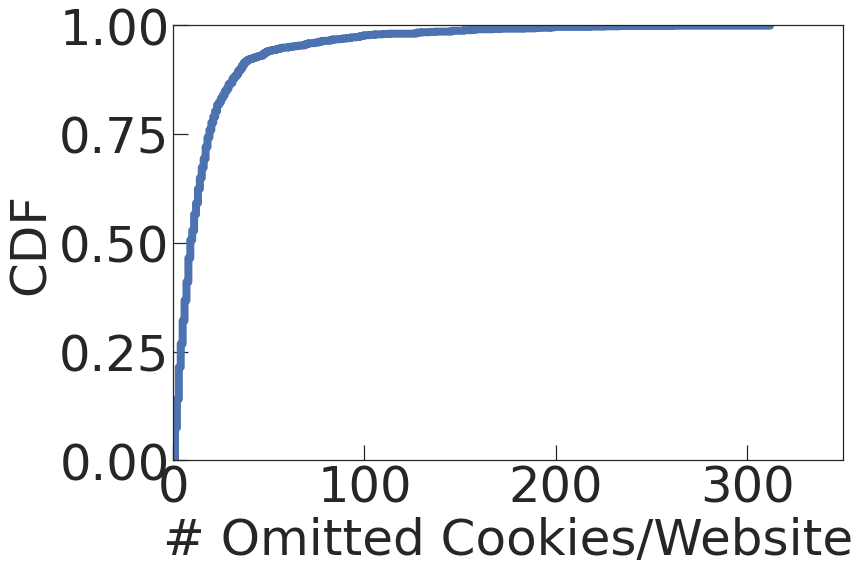

In [44]:
sns.set(rc={'figure.figsize':(12,8),"font.size":35,"axes.titlesize":30,"axes.labelsize":50},style="white", font_scale = 4.5)
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

ax = sns.ecdfplot(data=omit_counts, x=omit_counts.num_omit_cookies, linewidth=8)
ax.set(xlim=(0, 350))

plt.xlabel('# Omitted Cookies/Website')
plt.ylabel('CDF')
out_file = FIG_DIR / 'omit_cookie_cdf.pdf'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/omit_site.pdf


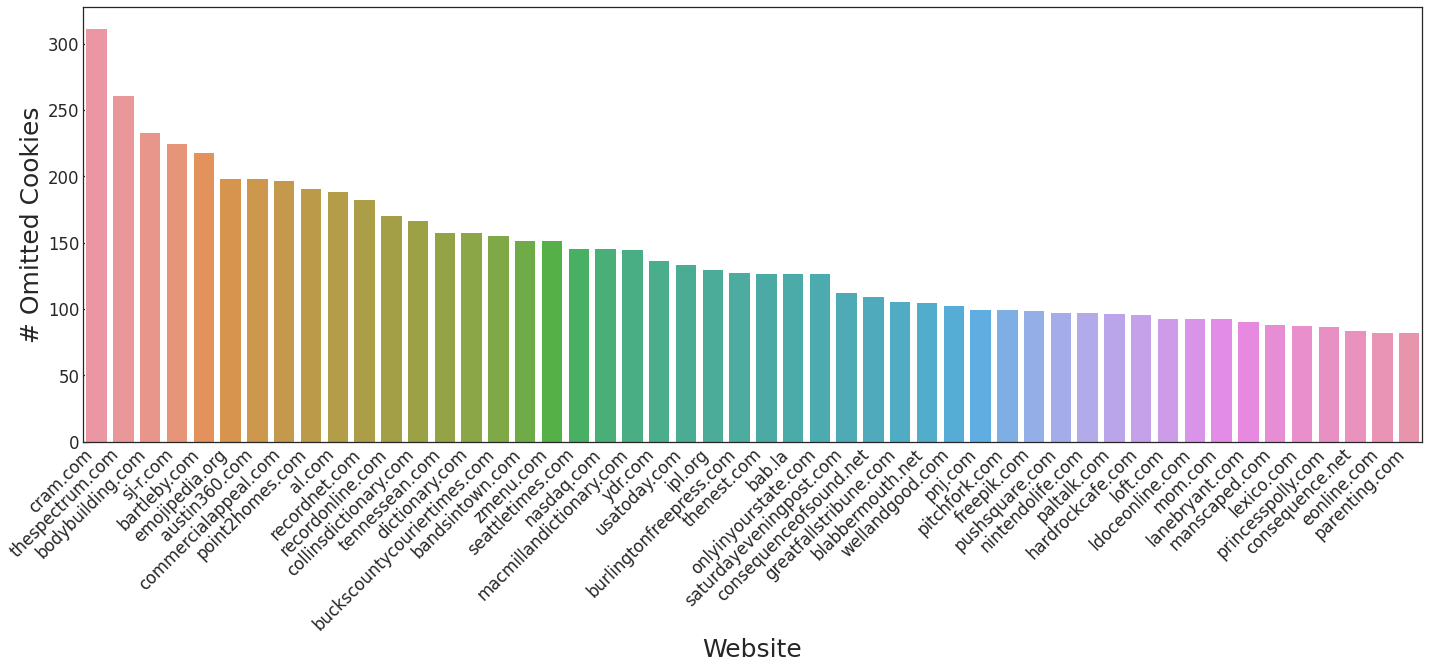

In [45]:
plot_df = omit_counts[:50]

sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x=plot_df.index, y=plot_df.num_omit_cookies)
ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=False, direction="in")
ax.set_ylabel('# Omitted Cookies')
ax.set_xlabel('Website')

out_file = FIG_DIR / 'omit_site.pdf'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [46]:
def plot_histogram_omit():
    sns.set(rc={'figure.figsize':(9,6),"font.size":25,"axes.titlesize":25,"axes.labelsize":15},style="white", font_scale = 1)
    omit_counts_histo = omit_complies.site.value_counts().value_counts()
    sns.barplot(x=omit_counts_histo.index, y=omit_counts_histo.values)
    ticks = plt.xticks(rotation=45, ha='right')

## Plot distribution of incorrectly enforced cookies

In [47]:
incor_complies = complies[complies.comply == 'incorrect']
# set(cookielist_sites) - set(omit_complies.site.unique())
incor_counts = incor_complies.site.value_counts().iloc[:50]
incor_counts = incor_counts.to_frame().reset_index().sort_values(by=['site', 'index'], ascending=[False, True])
incor_counts.columns

Index(['index', 'site'], dtype='object')

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/incor_site.pdf


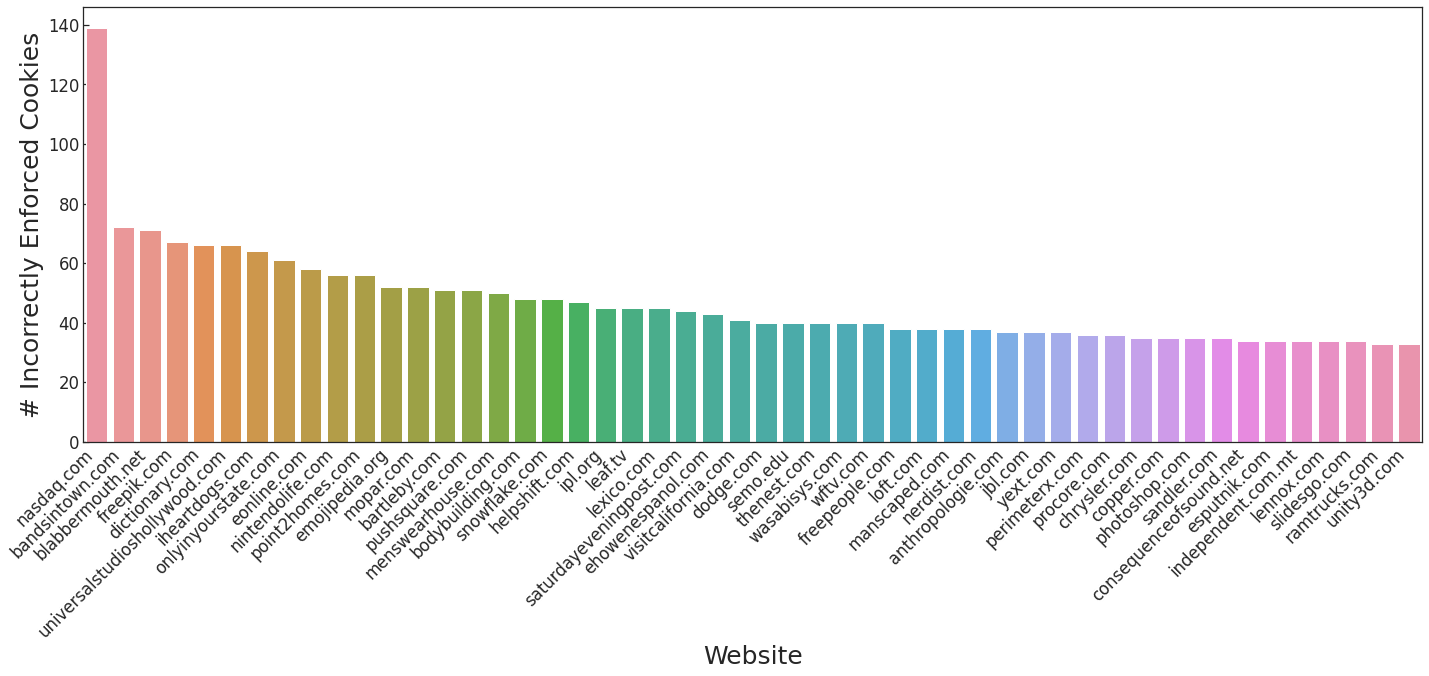

In [48]:
sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x='index', y='site', data=incor_counts)

ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=True, direction="in")
ax.set_ylabel('# Incorrectly Enforced Cookies')
ax.set_xlabel('Website')

out_file = FIG_DIR / 'incor_site.pdf'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [49]:
# len(incor_counts)

In [50]:
incor_counts[incor_counts.site == 33].reset_index(drop=True)

,index,site
0,ramtrucks.com,33
1,unity3d.com,33


### Top incorrect cookies

In [51]:
incor_cookies = complies[complies.comply == 'incorrect']

In [52]:
# site = 'onetrust.com'
# complies[complies.site == site].reset_index(drop=True)
# cookie_prefs[(cookie_prefs.site == site) & (cookie_prefs.name == '_gid')]

In [53]:
top_incor_cookies = incor_cookies.name.value_counts().sort_values(ascending=False).to_frame().reset_index().rename(columns={'index':'cookie_name', 'name': 'num_occur'})

In [54]:
top_incor_cookies['num_sites'] = top_incor_cookies.cookie_name.map(lambda cookie_name: incor_cookies[incor_cookies.name == cookie_name].site.nunique())

In [55]:
print(top_incor_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))

\begin{tabular}{lr}
\toprule
Cookie Name &  \# Websites \\
\midrule
        \_ga &         731 \\
       \_gid &         721 \\
       \_fbp &         480 \\
        IDE &         360 \\
    \_uetsid &         275 \\
\bottomrule
\end{tabular}



# Narrow cookie consent preferences

In [56]:
consent_cookies = sent_cookies[sent_cookies.name.isin(['OptanonConsent', 'CookieConsent'])][['domain', 'name', 'site']].drop_duplicates()
narrow_consent_cookies = consent_cookies[~consent_cookies.domain.str.startswith('.')].reset_index(drop=True)

In [57]:
set(contra_cookies.site).intersection(set(narrow_consent_cookies.site))

{'returnpath.com', 'returnpath.net', 'statista.com', 'validity.com'}

In [58]:
narrow_consent_cookies

,domain,name,site
0,www.aramex.com,CookieConsent,aramex.com
1,www.plesk.com,CookieConsent,plesk.com
2,blis.com,CookieConsent,blismedia.com
3,fsc.org,CookieConsent,fsc.org
4,www.userzoom.com,OptanonConsent,userzoom.com
...,...,...,...
227,www.freedomforum.org,CookieConsent,freedomforum.org
228,upserve.com,OptanonConsent,upserve.com
229,www.macquarie.com,OptanonConsent,macquarie.com
230,www.reiss.com,CookieConsent,reiss.com


# Case studies

In [59]:
incor_df = complies[complies.comply == 'incorrect']
incor_df.site.value_counts().sort_values(ascending=False).head()

nasdaq.com          139
bandsintown.com      72
blabbermouth.net     71
freepik.com          67
dictionary.com       66
Name: site, dtype: int64

In [60]:
case_site = 'blabbermouth.net'
incor_df[incor_df.site == case_site]

,name,domain,site,comply
1844334,__utmt,.blabbermouth.net,blabbermouth.net,incorrect
1844336,sessionId,ads.stickyadstv.com,blabbermouth.net,incorrect
1844338,loc,.addthis.com,blabbermouth.net,incorrect
1844339,__utmb,.blabbermouth.net,blabbermouth.net,incorrect
1844342,VISITOR_INFO1_LIVE,.youtube.com,blabbermouth.net,incorrect
...,...,...,...,...
1846010,MRM_UID,ads.stickyadstv.com,blabbermouth.net,incorrect
1846027,cnac,.id5-sync.com,blabbermouth.net,incorrect
1846099,id5,.id5-sync.com,blabbermouth.net,incorrect
1846185,car,.id5-sync.com,blabbermouth.net,incorrect


In [61]:
# cookie_prefs[(cookie_prefs.site == 'scientificamerican.com') & (cookie_prefs.name == 'MXP_TRACKINGID')]
cookie_prefs[(cookie_prefs.site == case_site) & (cookie_prefs.name == 'IDE')]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
100,IDE,doubleclick.net,390 days,C0004,Targeting/Advertising Cookies,active,blabbermouth.net,onetrust,en.json,False


In [62]:
# sent_cookies[(sent_cookies.site == 'scientificamerican.com') & (sent_cookies.name == 'MXP_TRACKINGID')]

In [63]:
omit_df = complies[complies.comply == 'omit']
omit_df.site.value_counts().sort_values(ascending=False).iloc[20:30]

macmillandictionary.com    145
ydr.com                    137
usatoday.com               134
ipl.org                    130
burlingtonfreepress.com    128
thenest.com                127
bab.la                     127
onlyinyourstate.com        127
saturdayeveningpost.com    113
consequenceofsound.net     110
Name: site, dtype: int64

In [64]:
print(omit_df[omit_df.site == 'scientificamerican.com'].reset_index().name.tolist())

[]


In [65]:
'uids' in omit_df[omit_df.site == 'scientificamerican.com'].reset_index().name.tolist()

False

In [66]:
omit_df[(omit_df.site == 'scientificamerican.com') & (omit_df.name == 'cftoken')]

,name,domain,site,comply


In [67]:
cookie_prefs[(cookie_prefs.site == 'scientificamerican.com') & (cookie_prefs.name == 'ADGRX_UID')]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent


In [68]:
all_sites = set(complies.site)
nothing_comply_sites = all_sites - set(complies[complies.comply == 'comply'].site)
print("Sites with no compliant cookies:", nothing_comply_sites)

Sites with no compliant cookies: {'userzoom.com', 'sheffield.ac.uk', 'ecdns.net', 'consequence.net', 'mobileworldlive.com', 'thomson.com', 'acm.org', 'groove.co', 'falcon.io', 'ifc.com', 'thehersheycompany.com', 'nexage.com', 'onetrust.com', 'jumptap.com', 'kew.org', 'health.org.uk', 'eonline.com', 'chambersandpartners.com', 'accenture.com', 'wasabisys.com', 'level3.com', 'appen.com', 'match.com', 'xrite.com', 'vfsglobal.com', 'perimeterx.com', 'adtech.com', 'level3.net', 'enneagraminstitute.com', 'uplynk.com', 'herokuapp.com', 'novartis.com', 'technicalseo.com', 'adtechus.com', 'rfef.es', 'pwc.co.uk', 'hersheys.com', 'sans.org', 'lumen.com', 'liveperson.net', 'infosys.com', 'ad.com', 'thomsonreuters.com', 'widespace.com', 'adtech.de', 'capitaliq.com', 'overture.com', 'recordnet.com', 'blabbermouth.net', 'consequenceofsound.net', 'uipath.com', 'oath.com', 'afrinic.net', 'foley.com', 'pentair.com', 'contentstack.io', 'gmu.edu', 'heroku.com', '24hourfitness.com', 'parenting.com', 'satche